# Limitation of predicting stock market price

Is it possible to predict stock market prices? I spent some time trying to find the best quantitative investment strategy, and I ended up making my own auto-trade algorithm program. It doesn't guarantee a profit. Coincidentally, machine learning has been my recent interest, and I have been trying to find a way to use machine learning technique in this investment strategy in a hope to increase the possibility to make profits. I was able to find many sources that seem to predict future stock price very accurately, and I was very excited to use them in my algorithm. As I studied more into it, I realized that none of them were useful. I would like to share my thoughts about it in this notebook.

We can easily find a lot of stock market data analysis that are open to public. While there are some meaningful analyses out there, I find that the attempt to predict the future stock prices can be hugely misleading. The prediction graphs that many data scientists generate may seem very accurate, but in fact, they show no meaningful analysis. There are tons of outside features that correlate to the stock market price fluctuation, so that the accurate prediction of the future stock price is nearly impossible. Therefore, when the result of the stock market prediction is overly accurate, we should expect that something is wrong with the interpretation of the analysis. The goal here is to review one of the most upvoted stock market data analysis in Kaggle and provide different aspect to the model.

In this notebook, I will refer to the stock market analysis of Fares Sayah and his prediction using LSTM. I want to make it clear that I have no intention to discredit his work. This is meant to provide a different perspective that can perhaps improve future stock market analysis. The link to his work is provided here:

https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm

This notebook consists of two main parts. In the first part, we will walk through the original model that was used to make prediction, and in the second part, we will assess the applicability of the model.

1. Walk Through the Original Model

2. Assess the Applicability of the Model

## 1. Walk Through the Original Model

The stock market analysis of Fares Sayah consists of 6 parts, and the future stock price prediction is done at the last part. A deep learning model LSTM, the abbreviation for Long Short Term Memory, is used to make the prediction. His model takes the stock price data of the past 60 days as an input and returns the prediction of the next day. In this notebook, we will use the same model structure, with a different stock data provided by Alpha Vantage. Alpha Vantage provides an open API that offers 20+ years of historical stock market data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read stock market data
df = pd.read_csv("./IBM_stock_market_data.csv", index_col = 0)

# Convert the index to datetime
df.index = pd.DatetimeIndex(df.index)

df.head()

,open,high,low,close,volume
1999-11-01,98.50,98.81,96.37,96.75,9551800
1999-11-02,96.75,96.81,93.69,94.81,11105400
1999-11-03,95.87,95.94,93.50,94.37,10369100
1999-11-04,94.44,94.44,90.00,91.56,16697600
1999-11-05,92.75,92.94,90.19,90.25,13737600


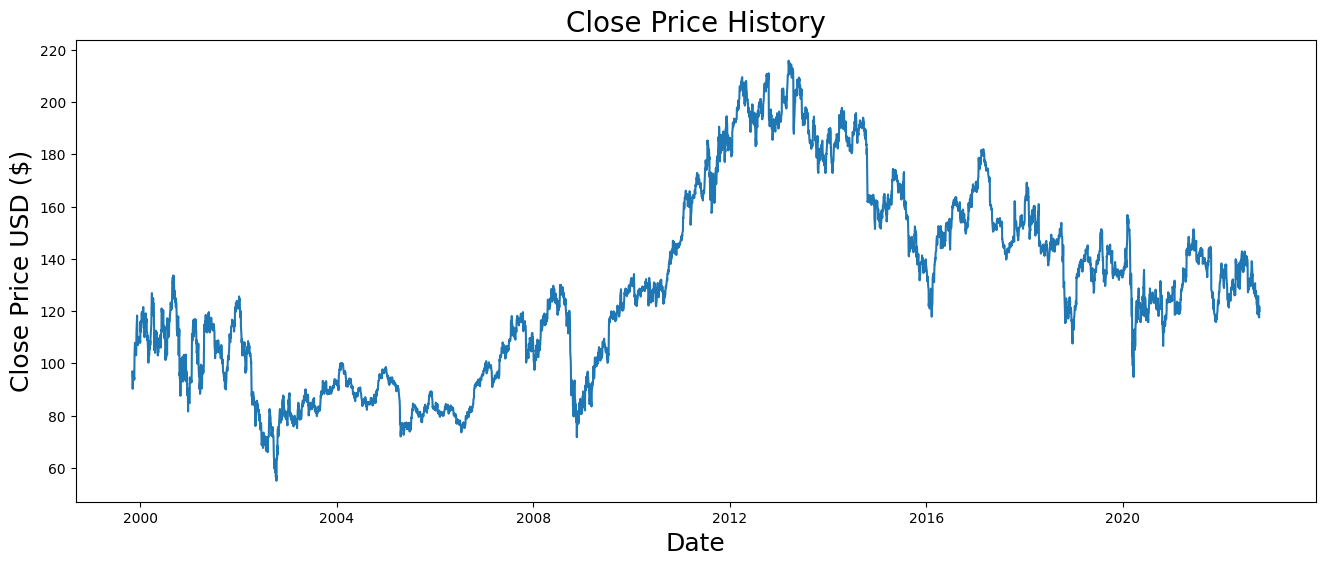

In [3]:
# Plot the stock data
plt.figure(figsize=(16,6))
plt.title('Close Price History', fontsize=20)
plt.plot(df['close'].astype(float))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [4]:
# Get the close prices from the dataframe
data = df.filter(["close"]).astype(float)
dataset = data.values

# divide the data into training data and test data
training_data_len = int(np.ceil(len(dataset)*.95))

print(f"Total Length of Dataset: {len(dataset)}")
print(f"Length of Training Dataset: {training_data_len}")
print(f"Length of Test Dataset: {len(dataset) - training_data_len}")

Total Length of Dataset: 5777
Length of Training Dataset: 5489
Length of Test Dataset: 288


In [5]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.25931687],
       [0.24724694],
       [0.24450943],
       ...,
       [0.38885087],
       [0.41510608],
       [0.40421825]])

The minmax scaler may not be an appropriate method since there is no maximum price in stock price. Nevertheless, we are going to stick to this since this is not the main issue with this model.

In [6]:
# Create scaled training dataset
train_data = scaled_data[0:int(training_data_len),:]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

# Convert to array and reshape
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

x_train.shape

(5429, 60, 1)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import os

# Turn off debugging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

2022-10-15 11:08:34.640259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-15 11:08:34.842097: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-15 11:08:34.861662: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-15 11:08:34.861690: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Now we are done designing the structure of the LSTM model. Before we move on to the next step, let's look closely at the summary of the model is shown below:

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


An input of any LSTM layer must follow this shape:

`(batch_size, time_steps, features)`

Batch size is simply the number of instances of the training set, which is 5429. We are using the data from the past 60 days to predict the next day's price, so the number of time steps is 60. The number of features is 1, since we are only using the close prices. Here is the input shape of this model:

`(5429, 60, 1)`

And here is the output shape of the first LSTM layer:

`(None, 60, 128)`

We have 128 as the size of output features. You might be misled to think that the model is drawing 128 traits from the past 60 days stock prices, but this is not how the LSTM is structured. Instead, the model is trying to draw 128 traits from only one feature. The model is too complex considering the very simple training data.

Let's move on to the next step.

In [9]:
# Train the model
history = model.fit(x_train, y_train, batch_size=1, epochs=1)

5429/5429 [==============================] - 103s 19ms/step - loss: 8.7980e-04


In [10]:
# Create test data
test_data = scaled_data[training_data_len-60:,:]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

# Convert to array and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [11]:
# Get the predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

9/9 [==============================] - 1s 17ms/step


In [12]:
# Get root mean squared error
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

3.022540581869404

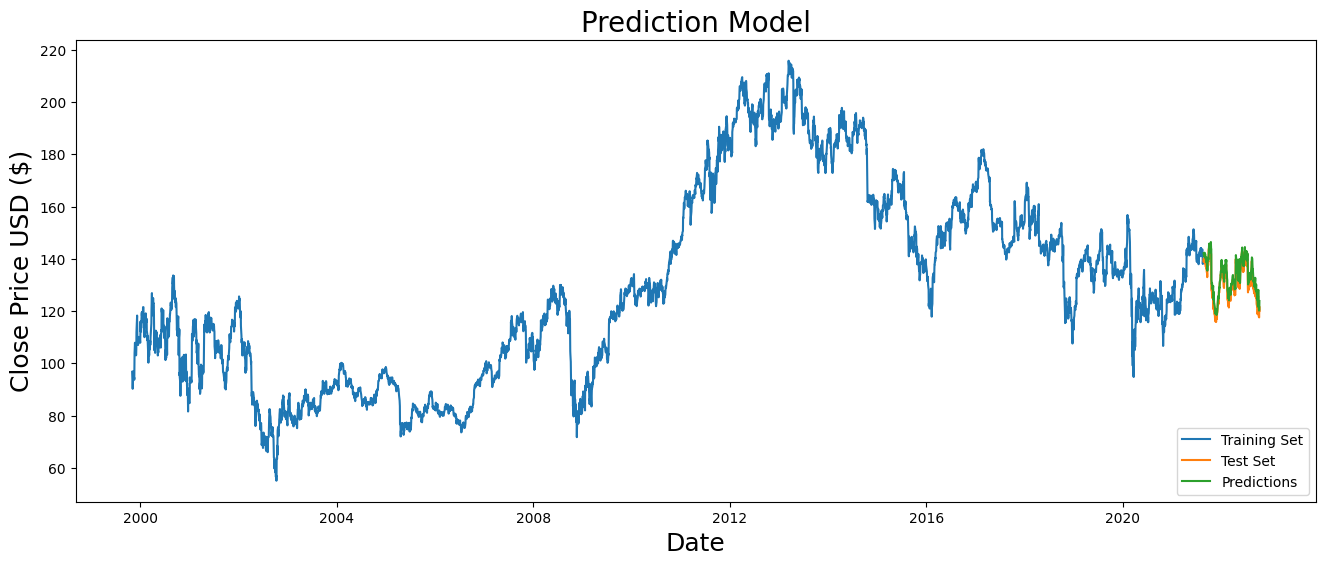

In [13]:
# Plot the data
train = data[:training_data_len].copy()
valid = data[training_data_len:].copy()
valid["Predictions"] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title("Prediction Model", fontsize = 20)
plt.xlabel("Date", fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train["close"])
plt.plot(valid[["close", "Predictions"]])
plt.legend(["Training Set", "Test Set", "Predictions"], loc = "lower right")
plt.show()

Here we have the visualized prediction model that many data scientists would come up with. The model seems to predict the future stock price very accurately, way too accurate to be suspicious. In fact, there is a huge flaw to this analysis. The model is only able to predict one day after, while the graph seems to tell you that this can predict for much longer than that. Therefore, the model that seems very accurate doesn't actually provide any meaningful result. The applicability of this model must be discussed, which will be done in the next part.

## 2. Assess the Applicability of the Model

When we make the stock market prediction model, we hope that this will help us with the investment decisions. Therefore, in order to assess the applicability of this model, we need to see if this model provides a meaningful result in regard to the investment. We will take two different approaches:

* Short Term Prediction: Focus on whether the model predicts an increase or a decrease.
* Long Term Prediction: Use predicted prices to predict the next one.
   
### Short Term Prediction: Focus on whether the model predicts an increase or a decrease

When we predict the price just a day after, the accuracy of the price itself is not a big concern (the stock price next day will be close to the day before anyway). What we truly want to know is whether the price increases or decreases. In the following notebook, we will change the target values into a binary form, which indicates either increase or decrease.

In [14]:
# Subtract previous day's price from the predicted price
# 0 for decrease, and 1 for increase
valid.loc[:,"Predicted Inc or Dec"] = ( valid["Predictions"] - valid["close"].shift() ) > 0
valid.loc[:,"Predicted Inc or Dec"] = valid["Predicted Inc or Dec"].copy().astype(int)

valid["Predicted Inc or Dec"].head()

2021-08-25    0
2021-08-26    1
2021-08-27    1
2021-08-30    1
2021-08-31    1
Name: Predicted Inc or Dec, dtype: int64

In [15]:
# Subtract previous day's price from the following day's price
# 0 for decrease, and 1 for increase
valid.loc[:,"Actual Inc or Dec"] = ( valid["close"] - valid["close"].shift() ) > 0
valid.loc[:,"Actual Inc or Dec"] = valid["Actual Inc or Dec"].astype(int)

valid["Actual Inc or Dec"].head()

2021-08-25    0
2021-08-26    0
2021-08-27    1
2021-08-30    0
2021-08-31    1
Name: Actual Inc or Dec, dtype: int64

In [16]:
from sklearn.metrics import confusion_matrix,classification_report

# Classification report
y_test = valid["Actual Inc or Dec"]
y_pred = valid["Predicted Inc or Dec"]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       147
           1       0.49      1.00      0.66       141

    accuracy                           0.49       288
   macro avg       0.75      0.50      0.34       288
weighted avg       0.75      0.49      0.33       288



In [17]:
# Confusion matrix
confusion_matrix(y_test, y_pred)

array([[  1, 146],
       [  0, 141]])

Unlike the very seemingly accurate graph above, this result tells a different story. We can see from the precision, recall, and F1-score that this is not any better than just simply guessing. This is not the model that you want to rely on when making invenstments.

### Long Term Prediction: Use predicted prices to predict the next one

We now know that this model may not be suitable for short term prediction. Then we want to know if this model is suitable for long term prediction. In order to do that, we need to assume that none of the future price data exist in the first place. We will predict one instance at a time, and then include that prediction for the next prediction.

In [18]:
# Create test data
test_data = scaled_data[training_data_len-60:training_data_len,:]

x_test = []
y_test = dataset[training_data_len:, :]
predictions = []

# Initial x_test consists only the stock price of 60 days
for i in range(0, 60):
    x_test.append(test_data[i,0])

# The model predicts the stock price of each day

for i in range(0 , len(scaled_data) - training_data_len):
    temp_x = x_test[i:i+60]
    temp_x = np.array(temp_x)
    temp_x = np.reshape(temp_x, (1, temp_x.shape[0], 1))
    temp_predict = model.predict(temp_x, verbose=0)
    predictions.append(temp_predict[0][0])
    
    # Append the prediction to the x_test, so that it will be used for the next prediction
    x_test.append(temp_predict[0][0])

# Convert to array and reshape
predictions = np.array(predictions)
predictions = np.reshape(predictions, (predictions.shape[0],1))
predictions.shape

(288, 1)

In [19]:
# Get the predicted price values using the scaler
predictions = scaler.inverse_transform(predictions)

In [20]:
# Get root mean squared error
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

88.63121085667838

In [21]:
# Plot the data
train = data[:training_data_len].copy()
valid2 = data[training_data_len:].copy()
valid2["Predictions"] = predictions
valid2.head()

,close,Predictions
2021-08-25,139.86,142.124969
2021-08-26,138.78,144.012970
2021-08-27,139.41,145.816406
2021-08-30,138.97,147.421036
2021-08-31,140.34,148.847458


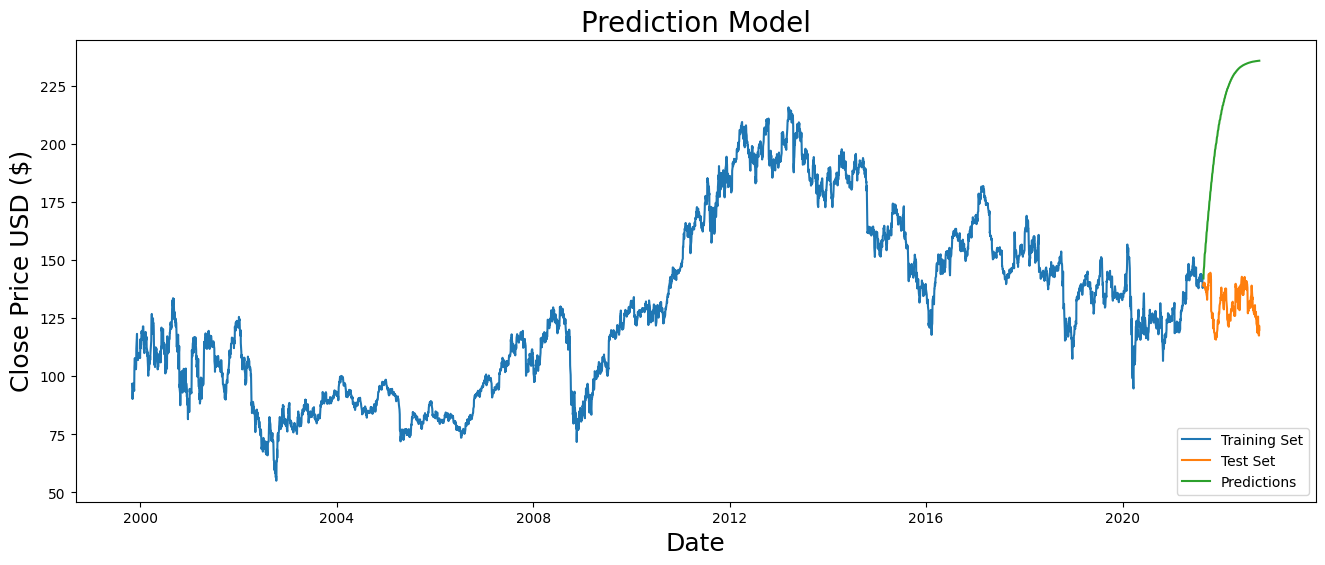

In [22]:
# Visualization
plt.figure(figsize=(16,6))
plt.title("Prediction Model", fontsize = 20)
plt.xlabel("Date", fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train["close"])
plt.plot(valid2[["close", "Predictions"]])
plt.legend(["Training Set", "Test Set", "Predictions"], loc = "lower right")
plt.show()

It can be easily seen from the visualization that the prediction doesn't provide a credible prediction. The model does not successfully predict the overall trend nor the fluctuations of the stock prices. The assessments show that this model fails to give any meaningful information.

## Conclusion

Stock market prediction is not an easy task because there is no guarantee that the same pattern in the past will repeat in the future. This is the area where even the experts and researchers don't aim for high accuracy. Yet, it seems to me that many people who have shallow knowledge about machine learning are susceptible to believe that such prediction is possible, due to many seemingly accurate predictions made by others. I hope this notebook will help the readers to realize the limitation of what machine learning can do. Nevertheless, there are some other approaches that you may want to try for your own study:

- Try shorter time range for each instance, such as using the data of 3 days to predict the next one day. It is highly unlikely that the trend 60 days before and the trend now matches.
- Consider other features that may correlate to the change in prices. Close price is not the only information that can be used to predict. There can be volumes, order book data, and so on.
- Making prediction in relation to other companies' stock prices is something to be considered also.
- Test different batch size and the number of epochs. Current model performs very differently each time it gets trained, meaning it's performance depends so much on randomness.